In [1]:
import pandas as pd
import spacy
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import csv
import sklearn
import re
import nltk
import pickle
import gensim
import gensim.corpora as corpora
import pyLDAvis
import pyLDAvis.gensim 

from gensim.test.utils import get_tmpfile
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel, LsiModel, LdaModel
from datetime import datetime

# Download stopwords
nltk.download('stopwords')
from nltk.corpus import stopwords
%matplotlib inline

[nltk_data] Downloading package stopwords to /home/jeff/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
print(datetime.now())

2019-06-18 13:55:34.865839


In [3]:
!python -m spacy download en_core_web_md

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_md')


In [4]:
sm_df = pd.read_json('studymoose.json', orient='records')
phd_df = pd.read_json('phdessay.json', orient='records')
raw_df = pd.concat([sm_df, phd_df], ignore_index=True)
len(raw_df)

85190

In [5]:
# Find text that only newline characters
pd.options.display.max_rows = 999

error_df = raw_df[raw_df['Text'].str.contains('\\n', regex=True)]
error_df = error_df[error_df['Text'].str.len() < 50]
drop_indices = error_df.index.tolist()

In [6]:
# Drop newlines
raw_df.drop(drop_indices, axis=0, inplace=True)
raw_df.reset_index(drop=True, inplace=True)
raw_df.tail()

,Paragraph,Tags,Text,Title,URL
84789,9,"[Change, Affect]",An employer may have to discontinue some insur...,Management Changes Affects Employee Morale,https://phdessay.com/management-changes-affect...
84790,10,"[Change, Affect]","Mossholder, K. W. , Richardson, H. A. , ; Sett...",Management Changes Affects Employee Morale,https://phdessay.com/management-changes-affect...
84791,11,"[Change, Affect]","California Management Review, 34(2), 9-28. Ret...",Management Changes Affects Employee Morale,https://phdessay.com/management-changes-affect...
84792,12,"[Change, Affect]","Academy of Management Journal, 35(5), 1086-109...",Management Changes Affects Employee Morale,https://phdessay.com/management-changes-affect...
84793,13,"[Change, Affect]",How to Cope When Coworkers Lose Their Jobs. Re...,Management Changes Affects Employee Morale,https://phdessay.com/management-changes-affect...


In [7]:
# Split each paragraph into sentences
sentences = raw_df.Text.str.split(r'[.!?] ', expand=True)

In [8]:
# Create a sentence-level data frame by joining the sentences to the raw_df
sent_df = raw_df.drop('Text', axis=1).join(
    sentences.stack().reset_index(drop=True, level=1).rename('Text'))
sent_df.head()

,Paragraph,Tags,Title,URL,Text
0,1,[Climate change],Climate Change (Class Project) Essay,https://studymoose.com/climate-change-class-pr...,Let’s first begin with “what is climate change...
0,1,[Climate change],Climate Change (Class Project) Essay,https://studymoose.com/climate-change-class-pr...,Climate change is caused by several factors [2]:
1,2,[Climate change],Climate Change (Class Project) Essay,https://studymoose.com/climate-change-class-pr...,* Internal forcing mechanism (Natural processe...
2,3,[Climate change],Climate Change (Class Project) Essay,https://studymoose.com/climate-change-class-pr...,"Since the formation of Earth, our planet’s cli..."
3,4,[Climate change],Climate Change (Class Project) Essay,https://studymoose.com/climate-change-class-pr...,The average temperature of the Earth’s surfac...


In [9]:
# Remove lines that are too short
short_df = sent_df[sent_df['Text'].str.len() < 15]
short_indices = short_df.index.tolist()
sent_df.drop(short_indices, axis=0, inplace=True)

In [10]:
sent_df.reset_index(drop=True, inplace=True)
len(sent_df)

243720

In [11]:
from string import punctuation
ref_indices = []
for i in range(len(sent_df)):
    text = sent_df.iloc[i, 4]
    punct = [c for c in text if c in punctuation]
    ratio = len(punct) / len(text)
    if ratio > 0.1:
        ref_indices.append(i)

In [12]:
sent_df.drop(ref_indices, axis=0, inplace=True)
len(sent_df)

241287

In [13]:
# Number each essay
n = 0
essay_dict = {}
for essay in sent_df.URL.unique():
    essay_dict[essay] = n
    n += 1

# Create an Essay column with the number of each essay
sent_df['Essay'] = sent_df['URL'].replace(essay_dict)
sent_df.reset_index(drop= True, inplace=True)
sent_df.head()

,Paragraph,Tags,Title,URL,Text,Essay
0,1,[Climate change],Climate Change (Class Project) Essay,https://studymoose.com/climate-change-class-pr...,Let’s first begin with “what is climate change...,0
1,1,[Climate change],Climate Change (Class Project) Essay,https://studymoose.com/climate-change-class-pr...,Climate change is caused by several factors [2]:,0
2,2,[Climate change],Climate Change (Class Project) Essay,https://studymoose.com/climate-change-class-pr...,* Internal forcing mechanism (Natural processe...,0
3,3,[Climate change],Climate Change (Class Project) Essay,https://studymoose.com/climate-change-class-pr...,"Since the formation of Earth, our planet’s cli...",0
4,4,[Climate change],Climate Change (Class Project) Essay,https://studymoose.com/climate-change-class-pr...,The average temperature of the Earth’s surfac...,0


In [14]:
# Tokenize/Lemmatize text

# Set stopwords for English
stop_words = stopwords.words('english')
stopped = []

for sent in sent_df.Text:
    stopped.append([word for word in sent.split(' ') if word not in stop_words])

# Remove stopwords
len(stopped)

241287

In [15]:
# Load spacy model for tokenizing
try:
    with open ('essays.pickle', 'rb') as fp:
        tokenized_sents = pickle.load(fp)
    print('Pretrained Model loaded!')
  
except:
    nlp = spacy.load('en_core_web_md')
    # Run NLP to get tokens
    tokenized_sents = []
    i = 0
    for sent in stopped:
        i += 1
        if i % 5000 == 0:
            print('Processing {}'.format(i))
        sent = ' '.join(sent)
        doc = nlp(sent)
        # Get lemmas for each word
        tokenized_sents.append([token.lemma_ for token in doc 
                                if not token.is_punct 
                                and token.has_vector 
                                and token.pos_ in ['PROPN', 
                                                   'VERB', 
                                                   'NOUN', 
                                                   'ADJ'] 
                                and not token.lemma_ in ['be', 'have', 'do']])
    
    with open('essays.pickle', 'wb') as fp:
        pickle.dump(tokenized_sents, fp)
    
    print('New model trained!')



Pretrained Model loaded!


In [16]:
# Run LSA on all texts
ts_df = sent_df.copy()
ts_df['Text'] = tokenized_sents
ts_df.head()

,Paragraph,Tags,Title,URL,Text,Essay
0,1,[Climate change],Climate Change (Class Project) Essay,https://studymoose.com/climate-change-class-pr...,"[let, first, begin, climate, change, significa...",0
1,1,[Climate change],Climate Change (Class Project) Essay,https://studymoose.com/climate-change-class-pr...,"[climate, change, cause, several, factor]",0
2,2,[Climate change],Climate Change (Class Project) Essay,https://studymoose.com/climate-change-class-pr...,"[internal, forcing, mechanism, natural, proces...",0
3,3,[Climate change],Climate Change (Class Project) Essay,https://studymoose.com/climate-change-class-pr...,"[formation, Earth, planet, ’s, climate, evolve...",0
4,4,[Climate change],Climate Change (Class Project) Essay,https://studymoose.com/climate-change-class-pr...,"[average, temperature, Earth, surface, period,...",0


In [17]:
essays = ts_df.groupby('Essay')['Text'].apply(lambda x: list(x))

In [18]:
paragraphs = ts_df.groupby(['Essay', 'Paragraph'])['Text'].apply(lambda x: list(x))
print(paragraphs[1])

Paragraph
1    [[Pakistan, fifth, large, population, country,...
2    [[Pakistan, issue, global, climate, change, Ky...
4    [[United, Nations, Pakistan, try, play, major,...
5    [[believe, Kyoto, Protocol, help, Pakistan, lo...
6    [[help, Pakistan, achieve, sustainable, develo...
Name: Text, dtype: object


In [19]:
# Run LDA on all texts
# Create Dictionary
id2word = corpora.Dictionary(essays[0])

for i in range(1, len(essays)):
    try:
        id2word.add_documents(essays[i])
    except:
        print('Error: {}'.format(i))
    if i % 500 == 0:
        print('Processed line {}'.format(i))
        
# Create Corpus
texts = []
for essay in essays:
    texts.append([e for para in essay for e in para])

# Term Document Frequency
corpus = []
for i in range(len(texts)):
    try:
        corpus.append(id2word.doc2bow(texts[i]))
    except:
        print('Error: {}'.format(i))

# View
print(corpus[:1])

Processed line 500
Processed line 1000
Processed line 1500
Processed line 2000
Processed line 2500
Processed line 3000
Processed line 3500
Processed line 4000
Processed line 4500
Processed line 5000
Processed line 5500
Processed line 6000
Processed line 6500
Processed line 7000
[[(0, 1), (1, 7), (2, 9), (3, 3), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 3), (11, 1), (12, 1), (13, 3), (14, 3), (15, 2), (16, 2), (17, 1), (18, 1), (19, 1), (20, 1), (21, 2), (22, 2), (23, 2), (24, 6), (25, 1), (26, 1), (27, 2), (28, 2), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 2), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 2), (43, 2), (44, 2), (45, 3), (46, 3), (47, 1), (48, 1), (49, 1), (50, 1), (51, 2), (52, 7), (53, 2), (54, 3), (55, 2), (56, 2), (57, 1), (58, 2), (59, 1), (60, 2), (61, 1), (62, 2), (63, 1), (64, 1), (65, 1), (66, 1), (67, 4), (68, 4), (69, 1), (70, 1), (71, 1), (72, 1), (73, 4), (74, 1), (75, 6), (76, 2), (77, 4), (78, 2), (79, 1), (80, 1), 

In [20]:
with open('corpus.pickle', 'wb') as fp:
        pickle.dump(corpus, fp)

In [21]:
try:
    lda16_model = LdaModel.load('lda16.model')
    
except:
    # Build LDA model
    lda16_model = LdaModel(corpus=corpus,
                         id2word=id2word,
                         num_topics=16,
                         update_every=1,
                         chunksize=100,
                         passes=10,
                         alpha='auto',
                         per_word_topics=True,
                         minimum_probability=1e-9)
    # Save model
    lda16_model.save('lda16.model')

/home/jeff/anaconda3/lib/python3.7/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/home/jeff/anaconda3/lib/python3.7/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/home/jeff/anaconda3/lib/python3.7/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-

In [22]:
# Write model info to dataframe
model = 'LDA'
n = 16
topics = lda16_model.print_topics()
perplexity = lda16_model.log_perplexity(corpus)

coherence_model_lda = CoherenceModel(model=lda16_model,
                                     texts=texts, 
                                     dictionary=id2word, 
                                     coherence='c_v')

coherence = coherence_model_lda.get_coherence()

model_info = pd.DataFrame.from_dict({'Model Type': model, 
                                     'Num_Topics': n, 
                                     'Topics': topics, 
                                     'Perplexity': perplexity, 
                                     'Coherence': coherence})

In [23]:
print(datetime.now())

2019-06-18 13:59:14.993058


In [24]:
try:
    lsa16_model = LsiModel.load('lsa16.model')
    
except:
    # Build LSA Model
    lsa16_model = LsiModel(corpus=corpus,
                        id2word=id2word,
                        num_topics=16, 
                        chunksize=100)

    lsa16_model.save('lsa16.model')

/home/jeff/anaconda3/lib/python3.7/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/home/jeff/anaconda3/lib/python3.7/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [25]:
# Add model info to dataframe
model = 'LSA'
n = 16
topics = lsa16_model.print_topics()
perplexity = 'N/A'

coherence_model_lsa = CoherenceModel(model=lsa16_model,
                                     texts=texts, 
                                     dictionary=id2word, 
                                     coherence='c_v')

coherence = coherence_model_lsa.get_coherence()

model_info = pd.concat([model_info,
                       pd.DataFrame.from_dict({'Model Type': model, 
                                     'Num_Topics': n, 
                                     'Topics': topics, 
                                     'Perplexity': perplexity, 
                                     'Coherence': coherence})], 
                      ignore_index=True)

In [26]:
model_info

,Model Type,Num_Topics,Topics,Perplexity,Coherence
0,LDA,16,"(0, 0.138*""child"" + 0.061*""family"" + 0.041*""ma...",-11.2642,0.555333
1,LDA,16,"(1, 0.148*""social"" + 0.104*""medium"" + 0.053*""i...",-11.2642,0.555333
2,LDA,16,"(2, 0.021*""year"" + 0.018*""change"" + 0.015*""inc...",-11.2642,0.555333
3,LDA,16,"(3, 0.043*""company"" + 0.027*""business"" + 0.025...",-11.2642,0.555333
4,LDA,16,"(4, 0.020*""society"" + 0.019*""culture"" + 0.015*...",-11.2642,0.555333
5,LDA,16,"(5, 0.032*""people"" + 0.022*""make"" + 0.020*""wou...",-11.2642,0.555333
6,LDA,16,"(6, 0.157*""woman"" + 0.058*""man"" + 0.036*""gende...",-11.2642,0.555333
7,LDA,16,"(7, 0.036*""drug"" + 0.032*""waste"" + 0.030*""food...",-11.2642,0.555333
8,LDA,16,"(8, 0.113*""water"" + 0.054*""climate"" + 0.034*""e...",-11.2642,0.555333
9,LDA,16,"(9, 0.031*""death"" + 0.021*""God"" + 0.018*""right...",-11.2642,0.555333


In [27]:
try:
    lda12_model = LdaModel.load('lda12.model')
    
except:
    # Build LDA model
    lda12_model = LdaModel(corpus=corpus,
                         id2word=id2word,
                         num_topics=12, 
                         update_every=1,
                         chunksize=100,
                         passes=10,
                         alpha='auto',
                         per_word_topics=True,
                         minimum_probability=1e-9)
    # Save model
    lda12_model.save('lda12.model')

/home/jeff/anaconda3/lib/python3.7/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/home/jeff/anaconda3/lib/python3.7/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/home/jeff/anaconda3/lib/python3.7/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-

In [28]:
print(datetime.now())

2019-06-18 13:59:53.486060


In [29]:
# Write model info to dataframe
model = 'LDA'
n = 12
topics = lda12_model.print_topics()
perplexity = lda12_model.log_perplexity(corpus)

coherence_model_lda = CoherenceModel(model=lda12_model,
                                     texts=texts, 
                                     dictionary=id2word, 
                                     coherence='c_v')

coherence = coherence_model_lda.get_coherence()

model_info = pd.concat([model_info,
                       pd.DataFrame.from_dict({'Model Type': model, 
                                     'Num_Topics': n, 
                                     'Topics': topics, 
                                     'Perplexity': perplexity, 
                                     'Coherence': coherence})], 
                      ignore_index=True)

In [30]:
try:
    lda20_model = LdaModel.load('lda20.model')
    
except:
    # Build LDA model
    lda20_model = LdaModel(corpus=corpus,
                         id2word=id2word,
                         num_topics=20, 
                         update_every=1,
                         chunksize=100,
                         passes=10,
                         alpha='auto',
                         per_word_topics=True,
                         minimum_probability=1e-9)
    # Save model
    lda20_model.save('lda20.model')

/home/jeff/anaconda3/lib/python3.7/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/home/jeff/anaconda3/lib/python3.7/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/home/jeff/anaconda3/lib/python3.7/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-

In [31]:
print(datetime.now())

2019-06-18 14:01:04.513491


In [32]:
# Write model info to dataframe
model = 'LDA'
n = 20
topics = lda20_model.print_topics()
perplexity = lda20_model.log_perplexity(corpus)

coherence_model_lda = CoherenceModel(model=lda20_model,
                                     texts=texts, 
                                     dictionary=id2word, 
                                     coherence='c_v')

coherence = coherence_model_lda.get_coherence()

model_info = pd.concat([model_info,
                       pd.DataFrame.from_dict({'Model Type': model, 
                                     'Num_Topics': n, 
                                     'Topics': topics, 
                                     'Perplexity': perplexity, 
                                     'Coherence': coherence})], 
                      ignore_index=True)

In [33]:
try:
    lda24_model = LdaModel.load('lda24.model')
    
except:
    # Build LDA model
    lda24_model = LdaModel(corpus=corpus,
                         id2word=id2word,
                         num_topics=24,
                         update_every=1,
                         chunksize=100,
                         passes=10,
                         alpha='auto',
                         per_word_topics=True,
                         minimum_probability=1e-9)
    # Save model
    lda24_model.save('lda24.model')

/home/jeff/anaconda3/lib/python3.7/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/home/jeff/anaconda3/lib/python3.7/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/home/jeff/anaconda3/lib/python3.7/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-

In [34]:
print(datetime.now())

2019-06-18 14:02:37.563293


In [35]:
# Write model info to dataframe
model = 'LDA'
n = 24
topics = lda24_model.print_topics(num_topics=24)
perplexity = lda24_model.log_perplexity(corpus)

coherence_model_lda = CoherenceModel(model=lda24_model,
                                     texts=texts, 
                                     dictionary=id2word, 
                                     coherence='c_v')

coherence = coherence_model_lda.get_coherence()

model_info = pd.concat([model_info,
                       pd.DataFrame.from_dict({'Model Type': model, 
                                     'Num_Topics': n, 
                                     'Topics': topics, 
                                     'Perplexity': perplexity, 
                                     'Coherence': coherence})], 
                      ignore_index=True)

In [36]:
try:
    lsa12_model = LsiModel.load('lsa12.model')
    
except:
    # Build LSA Model
    lsa12_model = LsiModel(corpus=corpus,
                        id2word=id2word,
                        num_topics=12, 
                        chunksize=100)

    lsa12_model.save('lsa12.model')

/home/jeff/anaconda3/lib/python3.7/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/home/jeff/anaconda3/lib/python3.7/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [37]:
# Add model info to dataframe
model = 'LSA'
n = 12
topics = lsa12_model.print_topics()
perplexity = 'N/A'

coherence_model_lsa = CoherenceModel(model=lsa12_model,
                                     texts=texts, 
                                     dictionary=id2word, 
                                     coherence='c_v')

coherence = coherence_model_lsa.get_coherence()

model_info = pd.concat([model_info,
                       pd.DataFrame.from_dict({'Model Type': model, 
                                     'Num_Topics': n, 
                                     'Topics': topics, 
                                     'Perplexity': perplexity, 
                                     'Coherence': coherence})], 
                      ignore_index=True)

In [38]:
try:
    lsa20_model = LsiModel.load('lsa20.model')
    
except:
    # Build LSA Model
    lsa20_model = LsiModel(corpus=corpus,
                        id2word=id2word,
                        num_topics=20, 
                        chunksize=100)

    lsa20_model.save('lsa20.model')

/home/jeff/anaconda3/lib/python3.7/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/home/jeff/anaconda3/lib/python3.7/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [39]:
# Add model info to dataframe
model = 'LSA'
n = 20
topics = lsa20_model.print_topics()
perplexity = 'N/A'

coherence_model_lsa = CoherenceModel(model=lsa20_model,
                                     texts=texts, 
                                     dictionary=id2word, 
                                     coherence='c_v')

coherence = coherence_model_lsa.get_coherence()

model_info = pd.concat([model_info,
                       pd.DataFrame.from_dict({'Model Type': model, 
                                     'Num_Topics': n, 
                                     'Topics': topics, 
                                     'Perplexity': perplexity, 
                                     'Coherence': coherence})], 
                      ignore_index=True)

In [40]:
try:
    lsa24_model = LsiModel.load('lsa24.model')
    
except:
    # Build LSA Model
    lsa24_model = LsiModel(corpus=corpus,
                        id2word=id2word,
                        num_topics=24, 
                        chunksize=100)

    lsa24_model.save('lsa24.model')

/home/jeff/anaconda3/lib/python3.7/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/home/jeff/anaconda3/lib/python3.7/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [41]:
# Add model info to dataframe
model = 'LSA'
n = 24
topics = lsa24_model.print_topics(num_topics=24)
perplexity = 'N/A'

coherence_model_lsa = CoherenceModel(model=lsa24_model,
                                     texts=texts, 
                                     dictionary=id2word, 
                                     coherence='c_v')

coherence = coherence_model_lsa.get_coherence()

model_info = pd.concat([model_info,
                       pd.DataFrame.from_dict({'Model Type': model, 
                                     'Num_Topics': n, 
                                     'Topics': topics, 
                                     'Perplexity': perplexity, 
                                     'Coherence': coherence})], 
                      ignore_index=True)

In [42]:
model_info.groupby('Coherence').count()

,Model Type,Num_Topics,Topics,Perplexity
Coherence,,,,
0.314257,24,24,24,24
0.332187,20,20,20,20
0.346081,16,16,16,16
0.352843,12,12,12,12
0.530264,12,12,12,12
0.537492,20,20,20,20
0.548872,24,24,24,24
0.555333,16,16,16,16


In [43]:
try:
    lda22_model = LdaModel.load('lda22.model')
    
except:
    # Build LDA model
    lda22_model = LdaModel(corpus=corpus,
                         id2word=id2word,
                         num_topics=22, 
                         update_every=1,
                         chunksize=100,
                         passes=10,
                         alpha='auto',
                         per_word_topics=True,
                         minimum_probability=1e-9)
    # Save model
    lda22_model.save('lda22.model')

/home/jeff/anaconda3/lib/python3.7/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/home/jeff/anaconda3/lib/python3.7/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/home/jeff/anaconda3/lib/python3.7/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-

In [44]:
print(datetime.now())

2019-06-18 14:06:41.494537


In [45]:
# Write model info to dataframe
model = 'LDA'
n = 22
topics = lda22_model.print_topics(num_topics=22)
perplexity = lda22_model.log_perplexity(corpus)

coherence_model_lda = CoherenceModel(model=lda22_model,
                                     texts=texts, 
                                     dictionary=id2word, 
                                     coherence='c_v')

coherence = coherence_model_lda.get_coherence()

model_info = pd.concat([model_info,
                       pd.DataFrame.from_dict({'Model Type': model, 
                                     'Num_Topics': n, 
                                     'Topics': topics, 
                                     'Perplexity': perplexity, 
                                     'Coherence': coherence})], 
                      ignore_index=True)
print('LDA Coherence: {}'.format(coherence))

LDA Coherence: 0.5245554906394557


In [46]:
try:
    lda26_model = LdaModel.load('lda26.model')
    
except:
    # Build LDA model
    lda26_model = LdaModel(corpus=corpus,
                         id2word=id2word,
                         num_topics=26, 
                         update_every=1,
                         chunksize=100,
                         passes=10,
                         alpha='auto',
                         per_word_topics=True,
                         minimum_probability=1e-9)
    # Save model
    lda26_model.save('lda26.model')

/home/jeff/anaconda3/lib/python3.7/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/home/jeff/anaconda3/lib/python3.7/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/home/jeff/anaconda3/lib/python3.7/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-

In [47]:
print(datetime.now())

2019-06-18 14:08:17.760750


In [48]:
# Write model info to dataframe
model = 'LDA'
n = 26
topics = lda26_model.print_topics(num_topics=26)
perplexity = lda26_model.log_perplexity(corpus)

coherence_model_lda = CoherenceModel(model=lda26_model,
                                     texts=texts, 
                                     dictionary=id2word, 
                                     coherence='c_v')

coherence = coherence_model_lda.get_coherence()

model_info = pd.concat([model_info,
                       pd.DataFrame.from_dict({'Model Type': model, 
                                     'Num_Topics': n, 
                                     'Topics': topics, 
                                     'Perplexity': perplexity, 
                                     'Coherence': coherence})], 
                      ignore_index=True)
print('LDA Coherence: {}'.format(coherence))

LDA Coherence: 0.494658413881929


In [49]:
try:
    lda28_model = LdaModel.load('lda28.model')
    
except:
    # Build LDA model
    lda28_model = LdaModel(corpus=corpus,
                         id2word=id2word,
                         num_topics=28,
                         update_every=1,
                         chunksize=100,
                         passes=10,
                         alpha='auto',
                         per_word_topics=True,
                         minimum_probability=1e-9)
    # Save model
    lda28_model.save('lda28.model')

/home/jeff/anaconda3/lib/python3.7/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/home/jeff/anaconda3/lib/python3.7/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/home/jeff/anaconda3/lib/python3.7/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-

In [50]:
print(datetime.now())

2019-06-18 14:10:06.435159


In [51]:
# Write model info to dataframe
model = 'LDA'
n = 28
topics = lda28_model.print_topics(num_topics=28)
perplexity = lda28_model.log_perplexity(corpus)

coherence_model_lda = CoherenceModel(model=lda28_model,
                                     texts=texts, 
                                     dictionary=id2word, 
                                     coherence='c_v')

coherence = coherence_model_lda.get_coherence()

model_info = pd.concat([model_info,
                       pd.DataFrame.from_dict({'Model Type': model, 
                                     'Num_Topics': n, 
                                     'Topics': topics, 
                                     'Perplexity': perplexity, 
                                     'Coherence': coherence})], 
                      ignore_index=True)
print('LDA Coherence: {}'.format(coherence))

LDA Coherence: 0.5227780682686342


/home/jeff/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2349: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if isinstance(obj, collections.Iterator):
/home/jeff/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2366: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  return list(data) if isinstance(data, collections.MappingView) else data
/home/jeff/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval

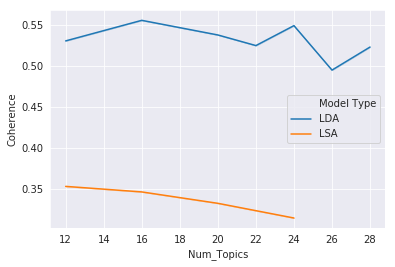

In [52]:
# Compare topic models
sns.set_style('darkgrid')

sns.lineplot(x='Num_Topics', 
             y='Coherence', 
             hue='Model Type', 
             data=model_info)
plt.show()

In [53]:
model_info.groupby('Coherence').count()

,Model Type,Num_Topics,Topics,Perplexity
Coherence,,,,
0.314257,24,24,24,24
0.332187,20,20,20,20
0.346081,16,16,16,16
0.352843,12,12,12,12
0.494658,26,26,26,26
0.522778,28,28,28,28
0.524555,22,22,22,22
0.530264,12,12,12,12
0.537492,20,20,20,20


In [54]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda16_model, corpus, id2word)
vis

/home/jeff/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
12     0.230009 -0.013224       1        1  19.483896
5      0.201493  0.065943       2        1  17.919563
4      0.183473  0.091903       3        1  11.809392
10     0.176233  0.104610       4        1  11.346959
2      0.184632 -0.091008       5        1   8.111960
3      0.174840 -0.158046       6        1   6.061250
9      0.047984  0.161883       7        1   5.619980
15    -0.085073  0.048776       8        1   3.635895
8     -0.060143 -0.306156       9        1   2.941261
11    -0.100885  0.024024      10        1   2.666248
13    -0.092895  0.050839      11        1   2.497576
7     -0.063446 -0.184547      12        1   2.363315
6     -0.135885  0.193173      13        1   2.329227
0     -0.178391  0.101975      14        1   1.901897
1     -0.202263 -0.109435      15        1   1.237689
14    -0.279684  0.019290      16        1   0.073893, topic_info=      Category          Freq               Term         Total  loglift  \
term                                                                     
240    Default   9616.000000             social   9616.000000  30.0000   
2760   Default   9215.000000              woman   9215.000000  29.0000   
403    Default   8364.000000              water   8364.000000  28.0000   
1170   Default   9293.000000             health   9293.000000  27.0000   
1240   Default   6596.000000              child   6596.000000  26.0000   
290    Default  14705.000000                use  14705.000000  25.0000   
1      Default  33299.000000             change  33299.000000  24.0000   
652    Default   7072.000000            company   7072.000000  23.0000   
456    Default   5814.000000                man   5814.000000  22.0000   
2788   Default   7701.000000           employee   7701.000000  21.0000   
509    Default   5024.000000             family   5024.000000  20.0000   
2878   Default   5335.000000             school   5335.000000  19.0000   
1831   Default   4433.000000            student   4433.000000  18.0000   
534    Default  20604.000000             people  20604.000000  17.0000   
2      Default   4640.000000            climate   4640.000000  16.0000   
2043   Default   4075.000000        information   4075.000000  15.0000   
1582   Default   5052.000000               care   5052.000000  14.0000   
1755   Default   3361.000000             medium   3361.000000  13.0000   
810    Default   6327.000000              right   6327.000000  12.0000   
67     Default   7756.000000              human   7756.000000  11.0000   
495    Default   3721.000000         technology   3721.000000  10.0000   
43     Default  11381.000000               life  11381.000000   9.0000   
546    Default   5666.000000               show   5666.000000   8.0000   
497    Default   5901.000000         government   5901.000000   7.0000   
1294   Default   7494.000000            society   7494.000000   6.0000   
528    Default   4689.000000           business   4689.000000   5.0000   
692    Default   9829.000000               work   9829.000000   4.0000   
1316   Default   5735.000000            culture   5735.000000   3.0000   
2579   Default   3412.000000            patient   3412.000000   2.0000   
585    Default   5116.000000              death   5116.000000   1.0000   
2207    Topic1   1607.081543        performance   1608.113770   1.6349   
916     Topic1   1276.786865              datum   1277.819092   1.6348   
927     Topic1   1188.373657           analysis   1189.405884   1.6347   
55      Topic1    792.505554             Change    793.537781   1.6343   
2210    Topic1    743.460205               tool    744.492432   1.6342   
3340    Topic1    701.728638        application    702.760864   1.6341   
2183    Topic1    629.032593          component    630.064819   1.6339   
2256    Topic1    572.039856      effectiveness    573.072083   1.6338   
1605    Topic1    580.277

In [55]:
pyLDAvis.save_html(vis, 'lda.html')

In [56]:
non_topics = [1.0, 2.0, 5.0, 12.0]

In [57]:
# Code attributed to https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/
def format_topics_sentences(ldamodel=lda16_model, corpus=corpus, texts=texts, non_topics=non_topics):
    # Init output
    essay_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row[0], key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if topic_num not in non_topics:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                essay_topics_df = essay_topics_df.append(pd.Series([int(topic_num), 
                                                                    round(prop_topic,4), 
                                                                    topic_keywords]), 
                                                         ignore_index=True)
                break
                
            else:
                continue
                
    essay_topics_df.columns = ['Dominant_Topic', 'Percent_Contrib', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    essay_topics_df = pd.concat([essay_topics_df, contents], axis=1)
    return(essay_topics_df)


df_topic_essay_keywords = format_topics_sentences(ldamodel=lda16_model, corpus=corpus, texts=texts)

# Format
df_dominant_topic = df_topic_essay_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Percent_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Percent_Contrib,Keywords,Text
0,0,8.0,0.2516,"water, climate, energy, temperature, plant, hu...","[let, first, begin, climate, change, significa..."
1,1,10.0,0.4379,"employee, government, state, public, system, p...","[Pakistan, fifth, large, population, country, ..."
2,2,8.0,0.2723,"water, climate, energy, temperature, plant, hu...","[historical, climate, change, profound, effect..."
3,3,8.0,0.4082,"water, climate, energy, temperature, plant, hu...","[great, challenge, earth, face, Global, Warmin..."
4,4,10.0,0.2406,"employee, government, state, public, system, p...","[discuss, challenge, global, warming, present,..."
5,5,3.0,0.1160,"company, business, product, market, country, e...","[Green, Cabs, friendly, taxi, company, New, Ze..."
6,6,10.0,0.3496,"employee, government, state, public, system, p...","[nation, adapt, climate, change, become, key, ..."
7,7,8.0,0.2258,"water, climate, energy, temperature, plant, hu...","[assume, year, continuous, temperature, record..."
8,8,8.0,0.2834,"water, climate, energy, temperature, plant, hu...","[Earth, fever, fever, rise, must, make, right,..."
9,9,8.0,0.2524,"water, climate, energy, temperature, plant, hu...","[put, simple, term, climate, change, refer, lo..."


In [58]:
# Code attributed to https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/
# Group top 5 essays under each topic
essay_topics_sorteddf = pd.DataFrame()

essay_topics_groupeddf = df_topic_essay_keywords.groupby('Dominant_Topic')

for i, grp in essay_topics_groupeddf:
    essay_topics_sorteddf = pd.concat([essay_topics_sorteddf, 
                                             grp.sort_values(['Percent_Contrib'], ascending=[0]).head(5)], 
                                            axis=0)

# Reset Index    
essay_topics_sorteddf.reset_index(drop=True, inplace=True)

# Format
essay_topics_sorteddf.columns = ['Topic_Num', "Topic_Percent_Contrib", "Keywords", "Text"]

# Show
essay_topics_sorteddf

,Topic_Num,Topic_Percent_Contrib,Keywords,Text
0,0.0,0.3790,"child, family, marriage, parent, school, educa...","[same, sex, marriage, legalize, deny, same, se..."
1,0.0,0.3754,"child, family, marriage, parent, school, educa...","[crystal, clear, empowering, girl, child, need..."
2,0.0,0.3601,"child, family, marriage, parent, school, educa...","[Amy, mother, child, daughter, twin, boy, girl..."
3,0.0,0.3577,"child, family, marriage, parent, school, educa...","[today, term, family, difficult, define, famil..."
4,0.0,0.3502,"child, family, marriage, parent, school, educa...","[change, society, family, structure, change, f..."
5,3.0,0.6875,"company, business, product, market, country, e...","[textile, industry, significant, segment, dist..."
6,3.0,0.6870,"company, business, product, market, country, e...","[globalization, concentrate, trade, commerce, ..."
7,3.0,0.6371,"company, business, product, market, country, e...","[less, extent, multinational, corporation, Wal..."
8,3.0,0.6150,"company, business, product, market, country, e...","[globalization, divide, economic, globalizatio..."
9,3.0,0.6126,"company, business, product, market, country, e...","[globalization, make, international, trade, ea..."


In [59]:
# Number of Documents for Each Topic
topic_counts = df_topic_essay_keywords.groupby('Topic_Keywords')['Dominant_Topic'].count()
topic_counts

Topic_Keywords
Canada, bus, Safety, flash, Red, selling, pupil, scatter, bathroom, unrelated                  1
child, family, marriage, parent, school, education, young, mother, age, sex                  210
company, business, product, market, country, economic, industry, customer, increase, new     734
death, God, right, law, crime, human, punishment, penalty, criminal, state                   665
drug, waste, food, use, disease, marijuana, effect, drink, test, experiment                  401
employee, government, state, public, system, policy, work, manager, issue, implement        1318
health, care, patient, welfare, medical, abortion, suicide, mental, individual, service      613
show, story, white, art, movie, character, black, play, al, use                              350
society, culture, social, group, religion, people, human, power, theory, leader             2050
student, school, police, bully, bullying, officer, teacher, gun, victim, youth               416
water, climate,

In [60]:
tags = ts_df.groupby('Essay')['Tags'].apply(lambda x: np.unique(x)[0])

In [61]:
# Get topics for tags
try:
    with open ('tags.pickle', 'rb') as fp:
        tokenized_tags = pickle.load(fp)
    print('Pretrained Model loaded!')

except:
    
    tokenized_tags =[]

    nlp = spacy.load('en_core_web_md')
    i = 0
    for tag in tags:
        i += 1
        if i % 500 == 0:
            print('Processing {}'.format(i))
        if tag is not None:
            tag = ' '.join(tag)
            doc = nlp(tag)
        else:
            doc = nlp('unknown')
            # Get lemmas for each word
        tokenized_tags.append([token.lemma_ for token in doc if not token.is_punct])
        
    with open('tags.pickle', 'wb') as fp:
        pickle.dump(tokenized_sents, fp)
    
    print('New model trained!')


Pretrained Model loaded!


In [62]:
# Create Corpus
texts = tokenized_tags

# Term Document Frequency
tag_corpus = []
for i in range(len(texts)):
    try:
        tag_corpus.append(id2word.doc2bow(texts[i]))
    except:
        print('Error: {}'.format(i))

In [ ]:
tags_topics_df = format_topics_sentences(ldamodel=lda16_model, corpus=tag_corpus, texts=tokenized_tags)
tags_topics_df.columns = ['Tag_Topic', 'Tag_Percent_Contrib', 'Tag_Keywords', 'Tags']
tags_topics_df.head()

In [ ]:
essaytags_topicsdf = df_dominant_topic.join(tags_topics_df)
tags = ts_df.groupby('Essay')['Tags'].apply(lambda x: list(x))
essaytags_topicsdf['Tags'] = [tag[0] for tag in tags]
essaytags_topicsdf.head()

In [ ]:
essaytags_topicsdf['match'] = essaytags_topicsdf.apply(
    lambda x : True if x['Dominant_Topic'] == x['Tag_Topic'] else False, axis=1)

In [ ]:
essaytags_topicsdf.match.value_counts()